In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from model import Generator
from utils import Loader, Config
from trainer import LadaGAN
from utils import deprocess
from plot_utils import plot_single_head
%matplotlib inline

In [2]:
loader = Loader()
loader.download('ffhq_128')
model_dir = './ffhq_128'

In [3]:
conf = Config(model_dir)

Config ./ffhq_128/config.json loaded
img_size: 128
batch_size: 64
g_lr: 0.0002
g_beta1: 0.5
g_beta2: 0.99
noise_dim: 128
g_initializer: orthogonal
g_dim: [1024, 512, 256]
g_heads: [4, 4, 4]
g_mlp: [512, 512, 512]
d_initializer: orthogonal
d_enc_dim: [32, 64, 128, 256]
d_out_dim: [512, 1024]
d_heads: 4
d_mlp: 512
d_lr: 0.0002
d_beta1: 0.5
d_beta2: 0.99
gp_weight: 0.0001
policy: color,translation,cutout
fid_batch_size: 50
gen_batch_size: 50
loss: nsl
ema_decay: 0.999
bcr: True
cr_weight: 0.1
dec_dim: [128, 64]
n_fid_real: 2500
n_fid_gen: 2500
plot_size: 5.2
test_seed: 77


In [4]:
noise = tf.random.normal([conf.batch_size, conf.noise_dim])
generator = Generator(
    img_size=conf.img_size, model_dim=conf.g_dim, 
    heads=conf.g_heads, mlp_dim=conf.g_mlp, dec_dim=conf.dec_dim 
)
gen_batch = generator(noise)
generator.summary()
print('G output shape:', gen_batch[0].shape)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 64, 1024)            8388608   
                                                                 
 positional_embedding (Posi  multiple                  65536     
 tionalEmbedding)                                                
                                                                 
 sm_ladaformer (SMLadaforme  multiple                  9715204   
 r)                                                              
                                                                 
 conv2d (Conv2D)             multiple                  1180160   
                                                                 
 positional_embedding_1 (Po  multiple                  131072    
 sitionalEmbedding)                                              
                                                         

In [5]:
gan = LadaGAN(
    generator=generator, discriminator=None, 
    conf=conf
)
gan.restore_generator(model_dir)

Best checkpoint restored from ./ffhq_128/best-training-checkpoints/ckpt-24064000


In [6]:
n = 12
noise_seed = tf.random.normal(
    [n, conf.noise_dim], seed=75489214
)

predictions, maps = gan.ema_generator(noise_seed, training=False)
predictions = tf.clip_by_value(deprocess(predictions), 0.0, 255.0)
predictions = tf.cast(predictions, tf.uint8).numpy()

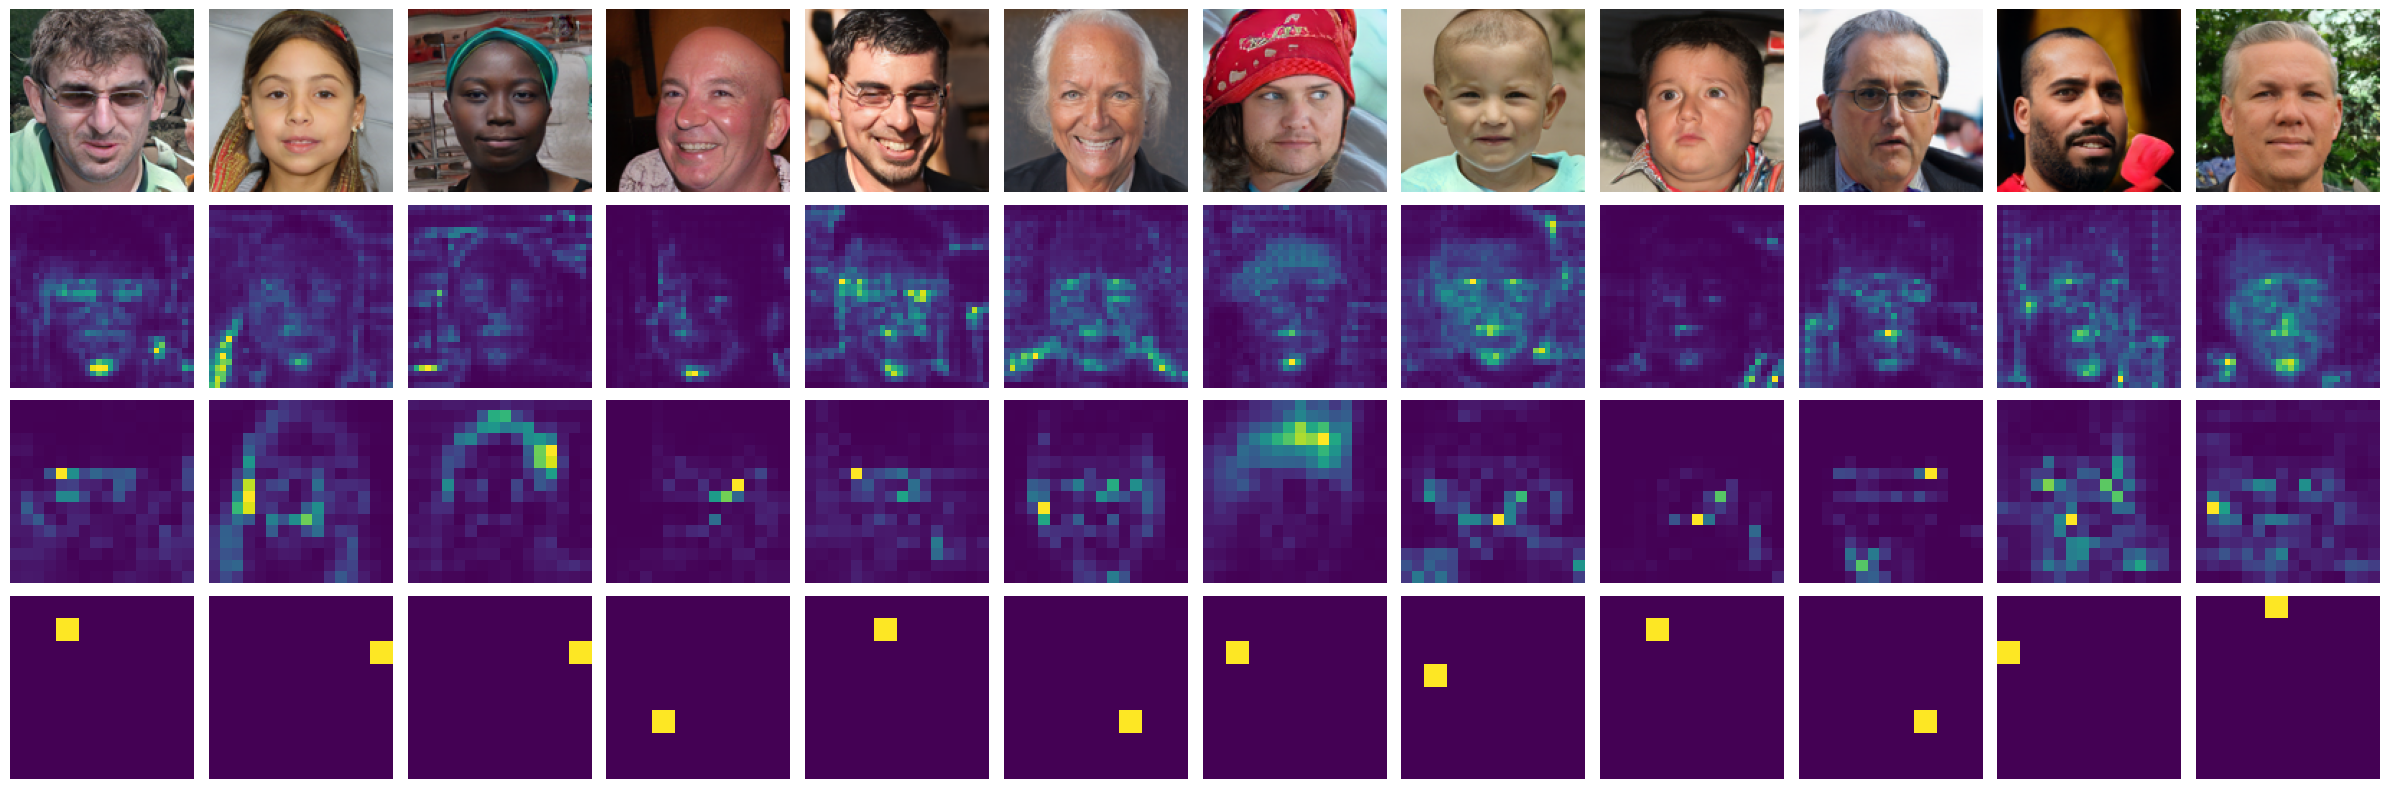

In [7]:
plot_single_head(predictions, maps, 1)